# Этап 1: Настройка окружения с MLflow, MySQL и MinIO

### Цели этапа:

1. Установить и запустить всё необходимое программное обеспечение.
2. Сохранить приложенный к проекту датасет в объектном хранилище MinIO.


## Создание необходимых директорий и файлов

In [17]:
import os

# Создание папки mlflow-server и вложенной папки mlflow
os.makedirs("mlflow-server/mlflow", exist_ok=True)

# Создание файлов внутри директорий
open("mlflow-server/docker-compose.yml", "w").close()
open("mlflow-server/mlflow/Dockerfile", "w").close()
open("mlflow-server/mlflow/requirements.txt", "w").close()
open("mlflow-server/.env", "w").close()


Такая конфигурация — упрощённая, но вполне работоспособная модель окружения, с которым вы можете столкнуться в своей профессиональной деятельности.

## Установка MLflow Server

Установка MLflow Server может быть выполнена несколькими способами:

### 1. Локальная установка через pip:

In [3]:
!pip install mlflow

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\win32\\_win32sysloader.pyd'
Consider using the `--user` option or check the permissions.




     --------------------------------------- 18.5/18.5 MB 19.2 MB/s eta 0:00:00
     ---------------------------------------- 189.5/189.5 kB ? eta 0:00:00
     ---------------------------------------- 41.2/41.2 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 83.5/83.5 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
     -------------------------------------- 148.1/148.1 kB 9.2 MB/s eta 0:00:00
     ------------------------------------- 226.0/226.0 kB 13.5 MB/s eta 0:00:00
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 9.3/9.3 MB 18.6 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3

In [4]:
!pip install mysql-connector-python==8.0.26
!pip install minio==7.1.0

     -------------------------------------- 799.6/799.6 kB 3.6 MB/s eta 0:00:00


     ---------------------------------------- 75.9/75.9 kB 1.0 MB/s eta 0:00:00


### 2. Запуск через Docker:
Если вы предпочитаете использовать контейнеры, вы можете запустить MLflow Server с помощью Docker. Это особенно полезно, если вы хотите изолировать MLflow от других частей вашей системы или если вы хотите запустить его на удаленном сервере.

### 3. Установка на облачной платформе:

MLflow также может быть развернут на облачных платформах, таких как AWS, Azure или GCP, что позволяет легко масштабировать и доступ к MLflow из любой точки мира.

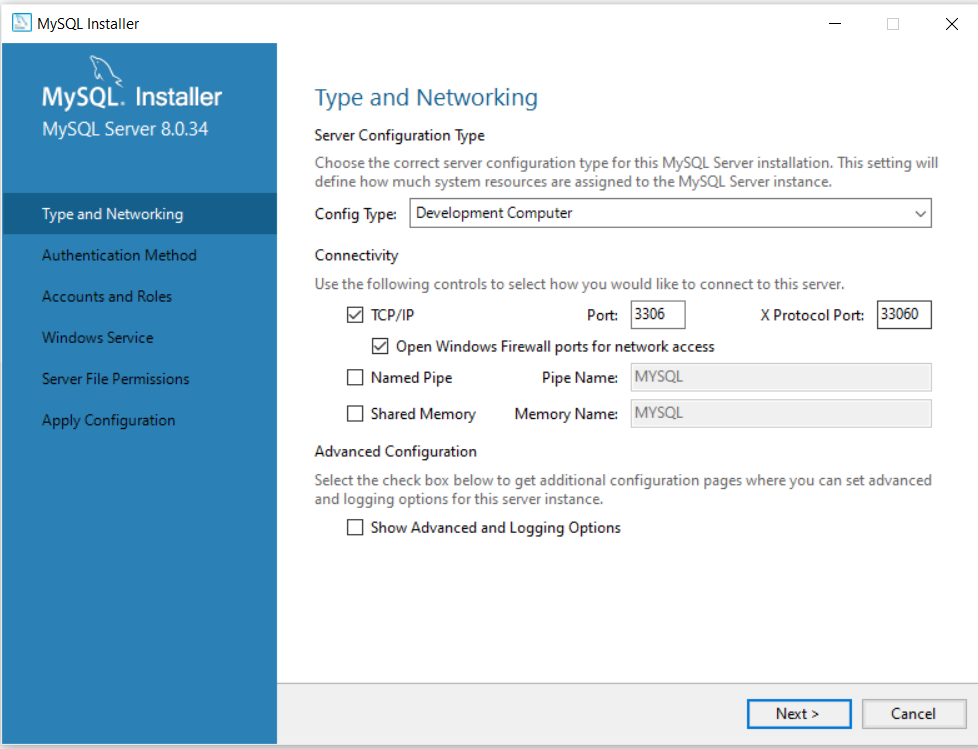

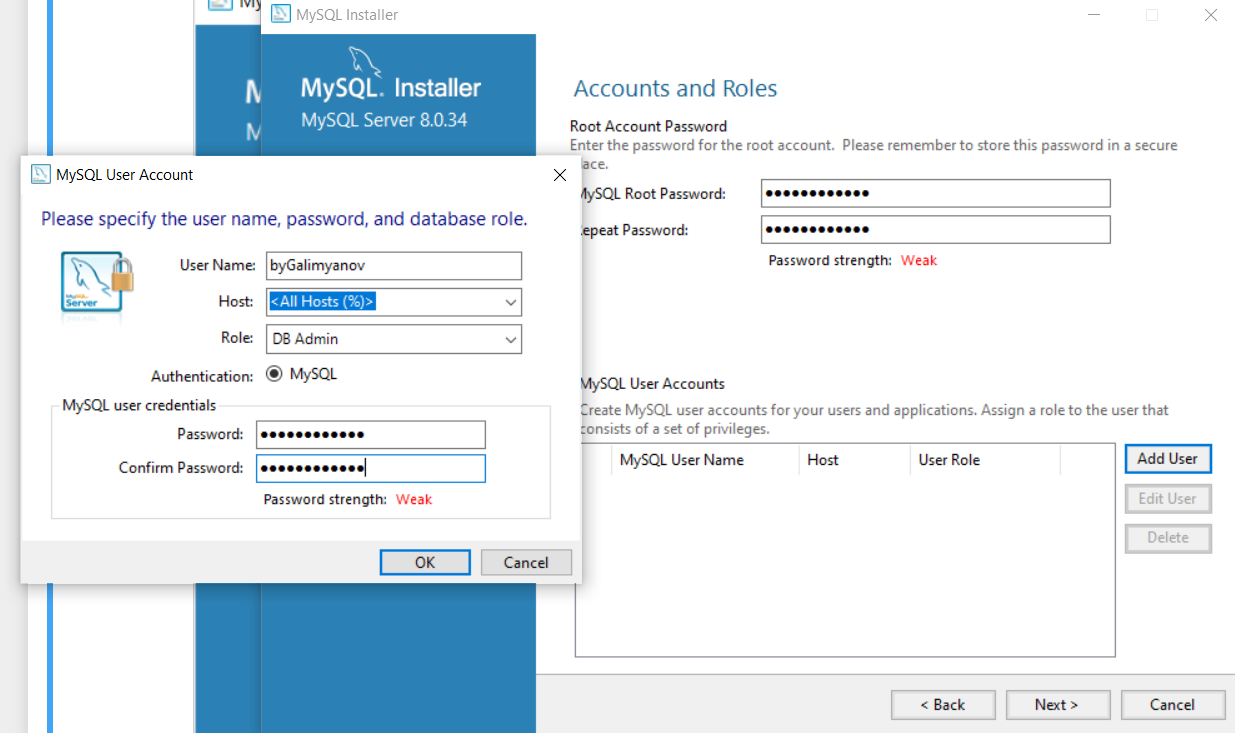

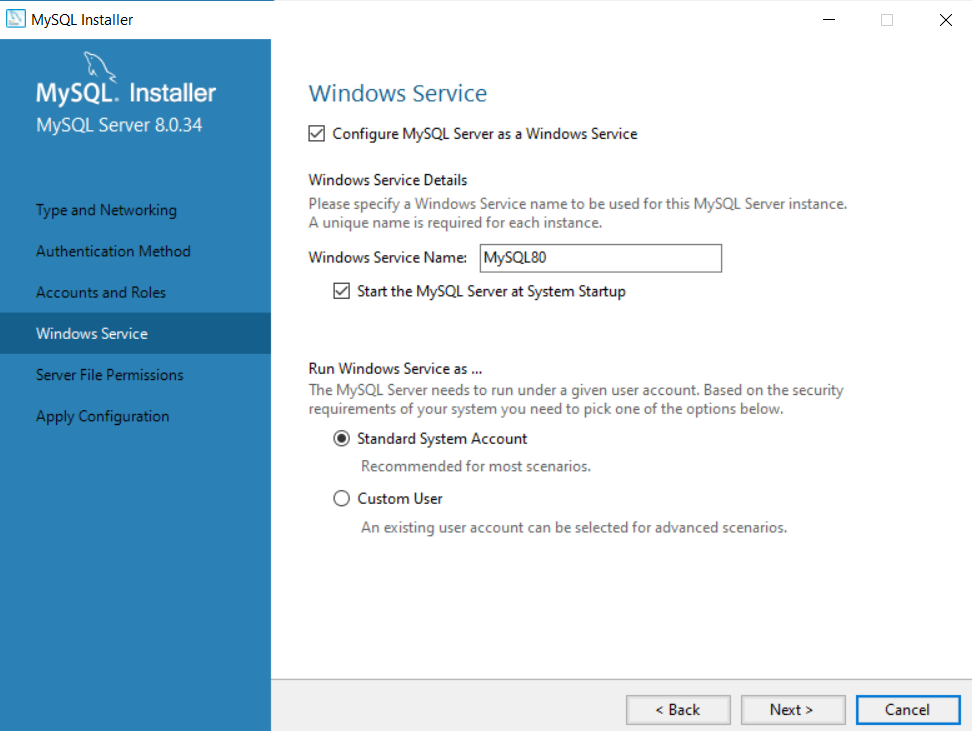

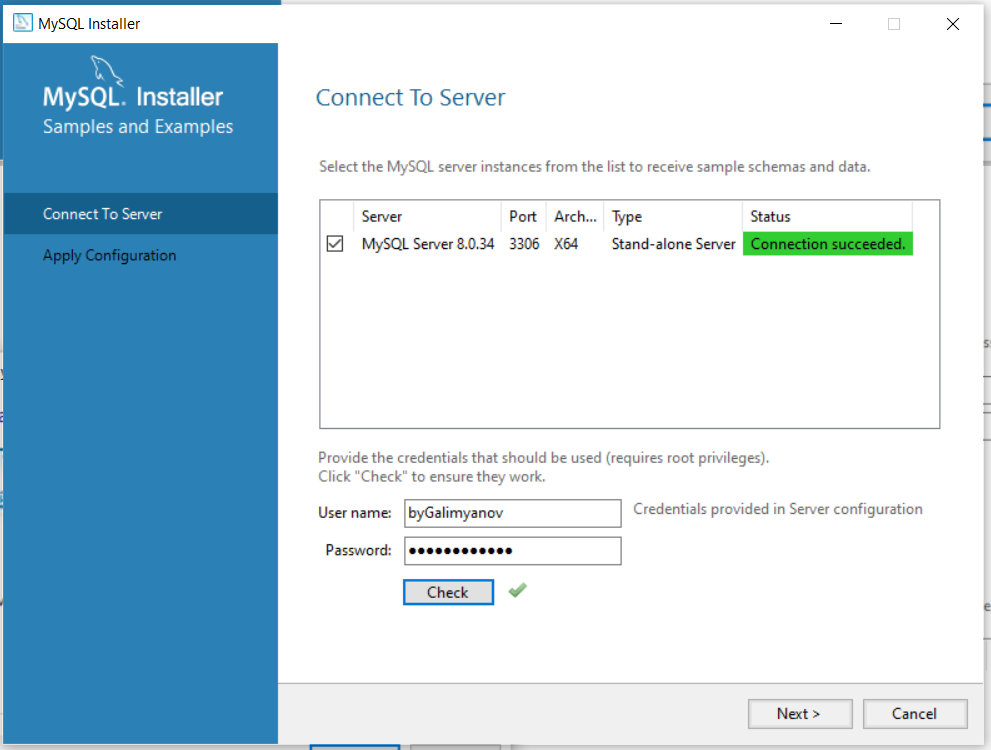

## Настройка манифеста Docker Compose

## Настройка Dockerfile для MLflow Server


In [73]:
docker_compose_content = """
version: '3.7'
services:
    minio:
        restart: always
        image: minio/minio@sha256:6d6cf693fd70ca6e15709fa44d39b44f98fc5b58795697486a95ac1cc2ad9880
        container_name: mlflow_s3
        ports:
            - "9000:9000"
            - "9001:9001"
        command: server /data --console-address ':9001' --address ':9000'
        environment:
            - MINIO_ROOT_USER=${AWS_ACCESS_KEY_ID}
            - MINIO_ROOT_PASSWORD=${AWS_SECRET_ACCESS_KEY}
        volumes:
            - minio_data:/data

    mc:
        image: minio/mc@sha256:3455a7bae6058ea83f797a95c0e29a4daedff6f79b1f87a0ede429e0344734ab
        depends_on:
            - minio
        container_name: mc
        env_file:
            - .env
        entrypoint: >
            /bin/sh -c "
            /tmp/wait-for-it.sh minio:9000 &&
            /usr/bin/mc alias set minio http://minio:9000 ${AWS_ACCESS_KEY_ID} ${AWS_SECRET_ACCESS_KEY} &&
            /usr/bin/mc mb minio/mlflow;
            exit 0;
            "
        volumes:
            - ./wait-for-it.sh:/tmp/wait-for-it.sh

    db:
        restart: always
        image: mysql/mysql-server@sha256:5b40d96b11333570143d98d3a74100fefadb9abb17b27a95dbc9ad33544ec142
        container_name: mlflow_db
        ports:
            - "3308:3306"
        environment:
            - MYSQL_DATABASE=${MYSQL_DATABASE}
            - MYSQL_USER=${MYSQL_USER}
            - MYSQL_PASSWORD=${MYSQL_PASSWORD}
            - MYSQL_ROOT_PASSWORD=${MYSQL_ROOT_PASSWORD}
        volumes:
            - dbdata:/var/lib/mysql

    web:
        restart: always
        build: ./mlflow
        image: mlflow_server
        container_name: mlflow_server
        depends_on:
            - mc
            - db
        ports:
            - "5000:5000"
        environment:
            - MLFLOW_S3_ENDPOINT_URL=http://minio:9000
            - AWS_ACCESS_KEY_ID=${AWS_ACCESS_KEY_ID}
            - AWS_SECRET_ACCESS_KEY=${AWS_SECRET_ACCESS_KEY}
        command: mlflow server --backend-store-uri mysql+pymysql://${MYSQL_USER}:${MYSQL_PASSWORD}@db:3306/${MYSQL_DATABASE} --default-artifact-root s3://mlflow/ --host 0.0.0.0

volumes:
    dbdata:
    minio_data:
"""

with open("mlflow-server/docker-compose.yml", "w") as file:
    file.write(docker_compose_content)


In [56]:
dockerfile_content = """
FROM python:3.10-slim-buster
# Install python packages
COPY requirements.txt /tmp
RUN pip install -r /tmp/requirements.txt


"""
with open("mlflow-server/mlflow/Dockerfile", "w") as file:
    file.write(dockerfile_content)

## Настройка requirements.txt для MLflow Server


In [21]:
requirements_content = """
cryptography==41.0.3
boto3==1.28.39
mlflow==2.6.0
pymysql==1.1.0
"""

with open("mlflow-server/mlflow/requirements.txt", "w") as file:
    file.write(requirements_content)


## Запуск сервисов с помощью Docker Compose


In [ ]:
# Очистка кэш Docker: 
# Иногда старый или поврежденный кэш может вызывать проблемы. 
# Вы можете попробовать очистить кэш с помощью команды
# Это удалит все контейнеры, образы и сети, которые не используются
# !docker system prune -a

     --------------------------------------- 18.5/18.5 MB 33.9 kB/s eta 0:00:00
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached sqlparse-0.4.4-py3-none-any.whl (41 kB)
  Using cached databricks_cli-0.17.7-py3-none-any.whl
  Using cached docker-6.1.3-py3-none-any.whl (148 kB)
  Using cached alembic-1.12.0-py3-none-any.whl (226 kB)
  Using cached waitress-2.1.2-py3-none-any.whl (57 kB)
  Using cached GitPython-3.1.36-py3-none-any.whl (189 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached pywin32-306-cp39-cp39-win_amd64.whl (9.3 MB)
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Attempting uninstall: pywin32
    Found existing installation: pywin32 302
    Uninstalling pywin32-302:
      Successfully uninstalled pywin32-302
  Rolling back uninstall of pywin32
  Moving to c:\users\admin\anaconda3\lib\site-packages\__pycache__\pythoncom.cpython-39.pyc
   from C:\Users\Admin

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\win32\\_win32sysloader.pyd'
Consider using the `--user` option or check the permissions.



In [16]:
# !cd mlflow-server && docker-compose --env-file config.env up -d --build

services.volumes Additional property minio_data is not allowed


In [74]:
!cd mlflow-server && docker-compose up -d --build

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 32B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 transferring context:
#2 transferring context: 2B 1.1s done
#2 DONE 1.2s

#3 [internal] load metadata for docker.io/library/python:3.10-slim-buster
#3 DONE 4.1s

#4 [1/3] FROM docker.io/library/python:3.10-slim-buster@sha256:37aa274c2d001f09b14828450d903c55f821c90f225fdfdd80c5180fcca77b3f
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 37B 0.7s done
#5 DONE 0.7s

#6 [2/3] COPY requirements.txt /tmp
#6 CACHED

#7 [3/3] RUN pip install -r /tmp/requirements.txt
#7 CACHED

#8 exporting to image
#8 exporting layers done
#8 writing image sha256:292463b23de8035cdc81f45677b41839a5077d940758a712ae0c842082ff34d3 done
#8 naming to docker.io/library/mlflow_server done
#8 DONE 0.0s


time="2023-09-23T00:24:38+03:00" level=warning msg="Found orphan containers ([mlflow-server-mlflow-1 mlflow-server-mysql-1]) for this project. If you removed or renamed this service in your compose file, you can run this command with the --remove-orphans flag to clean it up."
Container mlflow_db  Recreate
Container mlflow_s3  Running
Container mc  Created
Container mlflow_db  Recreated
Container mlflow_server  Recreate
Container mlflow_server  Recreated
Container mlflow_db  Starting
Container mc  Starting
Container mc  Started
Container mlflow_db  Started
Container mlflow_server  Starting
Container mlflow_server  Started


In [75]:
!docker ps

CONTAINER ID   IMAGE                COMMAND                  CREATED        STATUS                 PORTS                                     NAMES
032adce991e5   mlflow_server        "mlflow server --bacвЂ¦"   9 hours ago    Up 9 hours             0.0.0.0:5000->5000/tcp                    mlflow_server
70889fc8993a   mysql/mysql-server   "/entrypoint.sh mysqвЂ¦"   9 hours ago    Up 9 hours (healthy)   33060-33061/tcp, 0.0.0.0:3308->3306/tcp   mlflow_db
fa2f8eb4240d   minio/minio          "/usr/bin/docker-entвЂ¦"   12 hours ago   Up 12 hours            0.0.0.0:9000-9001->9000-9001/tcp          mlflow_s3


перезапустите ваш стек Docker, используя команду:

In [66]:
# !cd mlflow-server && docker-compose down

Container mlflow_server  Stopping
Container mlflow_server  Stopping
Container mlflow_server  Stopped
Container mlflow_server  Removing
Container mlflow_server  Removed
Container mlflow_db  Stopping
Container mlflow_db  Stopping
Container mc  Stopping
Container mc  Stopping
Container mc  Stopped
Container mc  Removing
Container mc  Removed
Container mlflow_s3  Stopping
Container mlflow_s3  Stopping
Container mlflow_s3  Stopped
Container mlflow_s3  Removing
Container mlflow_s3  Removed
Container mlflow_db  Stopped
Container mlflow_db  Removing
Container mlflow_db  Removed
Network mlflow-server_default  Removing
Network mlflow-server_default  Removed


Делаем вывод консольных команд с нормальной кодировкой

In [30]:
!chcp 65001

Active code page: 65001


In [33]:
!echo %cd%

C:\Users\Admin\Skillbox_ML_Experiments


После запуска сервисов проверьте доступность веб-интерфейсов:

[MLflow Server Interface](http://localhost:5000/)
[MinIO Interface](http://localhost:9001/)

### Сделайте коммит в гит-репозиторий, который подготовлен специально для вас. Поставьте на коммит тег: stage1. Задание будет считаться выполненным, если:

1. Ваш репозиторий содержит все необходимые файлы и папки: манифест docker-compose, который верно конфигурирует все сервисы, файл .env с переменными окружения и папку mlflow с Dockerfile для mlflow и requirements.txt с необходимыми python-пакетами.
2. Сервисы, которые сконфигурированы указанными файлами, запускаются.
3. На коммите в репозитории стоит правильный тег.
